In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Dataset

In [2]:
DS_PATH = '../datasets/'

In [3]:
X_df = pd.read_csv(f"{DS_PATH}bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb.txt", sep=' ', header=None, names=['x', 'y', 'z', 'intensity', 'r', 'g', 'b'])

In [4]:
X_df.head()

,x,y,z,intensity,r,g,b
0,20.623,40.276,-1.999,-1031,127,141,154
1,20.362,40.375,-2.239,-941,130,141,159
2,20.360,40.376,-2.402,-1083,139,151,165
3,20.374,40.367,-2.405,-1122,131,147,163
4,20.372,40.366,-2.405,-1165,132,145,161


In [5]:
X_df.shape

(29697591, 7)

In [6]:
labels_df = pd.read_csv(f"{DS_PATH}sem8_labels_training/sem8_labels_training/bildstein_station1_xyz_intensity_rgb.labels", sep='\r\n', header=None, names=['label'], engine='python')

In [7]:
labels_df.head()

,label
0,0
1,0
2,6
3,0
4,0


In [8]:
labels_df.shape

(29697591, 1)

In [9]:
df = pd.concat([X_df[['x', 'y', 'z']], labels_df], axis=1)

df.head()

,x,y,z,label
0,20.623,40.276,-1.999,0
1,20.362,40.375,-2.239,0
2,20.360,40.376,-2.402,6
3,20.374,40.367,-2.405,0
4,20.372,40.366,-2.405,0


## Data Cleaning

### Null Data

In [10]:
df.isnull().sum()

x        0
y        0
z        0
label    0
dtype: int64

### Duplicated Data

In [11]:
df.duplicated().sum()

624770

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

In [14]:
df.shape

(29072821, 4)

## Exploratory Data Analysis

### Target Label Distribution

Text(0, 0.5, 'Count (millions)')

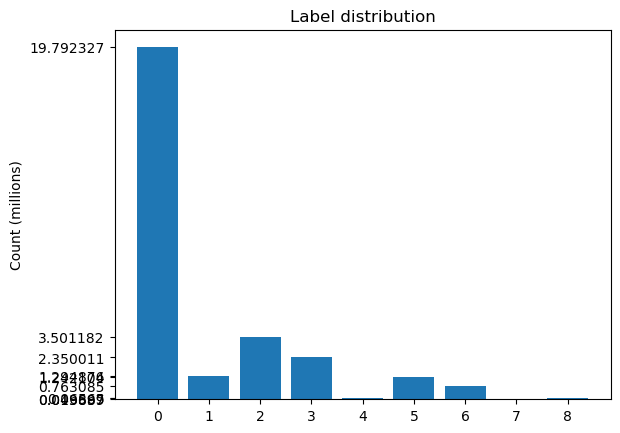

In [15]:
labels, counts = np.unique(df['label'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(labels, counts, align='center')
ax.set_xticks(labels)
ax.set_yticks(counts)
ax.set_yticklabels(counts / 1_000_000)
ax.set_title('Label distribution')
ax.set_ylabel('Count (millions)')

## PyTorch Dataset

In [16]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = MinMaxScaler()

X_train = torch.from_numpy(scaler.fit_transform(X_train))
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(scaler.transform(X_test))
y_test = torch.from_numpy(y_test)

In [17]:
X_train.shape

torch.Size([23258256, 3])

In [18]:
y_train.shape

torch.Size([23258256])

In [19]:
X_test.shape

torch.Size([5814565, 3])

In [20]:
y_test.shape

torch.Size([5814565])

In [21]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)

In [23]:
train_dl = DataLoader(train_ds, batch_size=4096, shuffle=True)

In [24]:
x_bs, y_bs = next(iter(train_dl))
print(f"x_bs.shape: {x_bs.shape}")
print(f"y_bs.shape: {y_bs.shape}")

x_bs.shape: torch.Size([4096, 3])
y_bs.shape: torch.Size([4096])


In [25]:
ds_batch_size = 1
number_of_features = x_bs.shape[1]
number_of_points = x_bs.shape[0]

x_bs = x_bs.reshape(ds_batch_size, number_of_features, number_of_points)

x_bs.shape

torch.Size([1, 3, 4096])

# Model

## TNet

In [44]:
class SharedMLPBlock(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 min_batch_size_for_batch_norm: int = 2):
        super().__init__()
        
        self.min_batch_size_for_batch_norm = min_batch_size_for_batch_norm
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        self.bn = nn.BatchNorm1d(out_channels)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            X (torch.Tensor): Input of size (batch_size, in_channels, number_of_points).

        Returns:
            torch.Tensor: Output of size (batch_size, out_channels, number_of_points).
        """
        
        batch_size = X.shape[0]
        
        X = self.conv(X)
        
        if (batch_size >= self.min_batch_size_for_batch_norm and self.training) or not self.training:
            X = self.bn(X)
        
        X = F.relu(X)
        
        return X


class MLPBlock(nn.Module):
    def __init__(self, 
                 in_features: int, 
                 out_features: int, 
                 min_batch_size_for_batch_norm: int = 2):
        super().__init__()
        
        self.min_batch_size_for_batch_norm = min_batch_size_for_batch_norm
        self.fc = nn.Linear(in_features=in_features, out_features=out_features)
        self.bn = nn.BatchNorm1d(out_features)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Args:
            X (torch.Tensor): Input of size (batch_size, in_features).

        Returns:
            torch.Tensor: Output of size (batch_size, out_features).
        """
        
        batch_size = X.shape[0]
        
        X = self.fc(X)
        
        if (batch_size >= self.min_batch_size_for_batch_norm and self.training) or not self.training:
            X = self.bn(X)
        
        X = F.relu(X)
        
        return X
    

class TNet(nn.Module):
    def __init__(self, 
                 number_of_features: int,
                 min_batch_size_for_batch_norm: int = 2):
        """Transformation Network.

        Args:
            number_of_features (int): Number of features for the point cloud.
        """
        super().__init__()
        
        self.number_of_features = number_of_features
        
        identity_matrix = torch.eye(self.number_of_features, requires_grad=True).reshape(-1)
        if identity_matrix.is_cuda:
            identity_matrix=identity_matrix.cuda()
        self.identity_matrix = identity_matrix
        
        self.feature_extraction_blocks = nn.Sequential(
            SharedMLPBlock(in_channels=self.number_of_features, out_channels=64, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=64, out_channels=128, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=128, out_channels=1024, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        )
        
        self.mlp = nn.Sequential(
            MLPBlock(in_features=1024, out_features=512, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            MLPBlock(in_features=512, out_features=256, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            nn.Linear(in_features=256, out_features=number_of_features * number_of_features)
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Args:
            X (torch.Tensor): Input of size (batch_size, number_of_features, number_of_points)
        
        Returns:
            torch.Tensor: Output of size (batch_size, number_of_features, number_of_features)
        """
        X = self.feature_extraction_blocks(X) # Ouput: (batch_size, 1024, number_of_points)
        
        number_of_points = X.shape[-1]
        X = F.max_pool1d(X, kernel_size=number_of_points, stride=1, padding=0).squeeze(dim=-1) # Ouput: (batch_size, 1024)
        
        X = self.mlp(X) # Ouput: (batch_size, number_of_features * number_of_features)
        
        X = X + self.identity_matrix # Ouput: (batch_size, number_of_features * number_of_features)
        
        X = X.reshape(-1, self.number_of_features, self.number_of_features) # Ouput: (batch_size, number_of_features, number_of_features)

        return X

## PointNet

In [52]:
class PointNetEncoder(nn.Module):
    def __init__(self, 
                 number_of_features: int, 
                 number_of_classes: int, 
                 min_batch_size_for_batch_norm: int = 2):
        super().__init__()
        
        self.number_of_features = number_of_features
        self.number_of_classes = number_of_classes
        
        self.tnet_inputs_transformer = TNet(number_of_features=self.number_of_features)
        
        self.shared_mlp_1 = nn.Sequential(
            SharedMLPBlock(in_channels=self.number_of_features, out_channels=64, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=64, out_channels=64, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        )
        
        self.tnet_features_transformer = TNet(number_of_features=64)
        
        self.shared_mlp_2 = nn.Sequential(
            SharedMLPBlock(in_channels=64, out_channels=64, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=64, out_channels=128, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=128, out_channels=1024, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        )
    
    def forward(self, X: torch.Tensor) -> tuple:
        """

        Args:
            X (torch.Tensor): Input of size (batch_size, number_of_features, number_of_points)

        Returns:
            tuple: two torch.Tensor : One of size (batch_size, 64, number_of_points) and one of size (batch_size, 1024, 1).
            The first output is the local features extracted by the network and the second one is the global features.
        """
        X = X.float()
        
        inputs_transform = self.tnet_inputs_transformer(X) # Output: (batch_size, number_of_features, number_of_features)
        
        X = torch.bmm(X.transpose(2,1), inputs_transform).transpose(2,1) # Output: (batch_size, number_of_features, number_of_points)
        
        X = self.shared_mlp_1(X) # Output: (batch_size, 64, number_of_points)
        
        features_transform = self.tnet_features_transformer(X) # Output: (batch_size, 64, 64)
        
        local_features = torch.bmm(X.transpose(2,1), features_transform).transpose(2,1) # Output: (batch_size, 64, number_of_points)
        
        X = self.shared_mlp_2(local_features) # Output: (batch_size, 1024, number_of_points)
        
        global_features = F.max_pool1d(X, kernel_size=X.shape[-1], stride=1, padding=0) # Output: (batch_size, 1024, 1)
        
        return (local_features, global_features)

In [64]:
class PointNetClassification(nn.Module):
    def __init__(self, 
                 number_of_features: int, 
                 number_of_classes: int, 
                 min_batch_size_for_batch_norm: int = 2):
        super().__init__()
        
        self.number_of_features = number_of_features
        self.number_of_classes = number_of_classes
        self.min_batch_size_for_batch_norm = min_batch_size_for_batch_norm
        
        self.encoder = PointNetEncoder(number_of_features=number_of_features,
                                       number_of_classes=number_of_classes,
                                       min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        
        self.classification_mlp = nn.Sequential(
            MLPBlock(in_features=1024, out_features=512, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            MLPBlock(in_features=512, out_features=256, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=256, out_features=number_of_classes), 
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """

        Args:
            X (torch.Tensor): Input of size (batch_size, number_of_features, number_of_points)

        Returns:
            torch.Tensor: Output of size (batch_size, number_of_classes)
        """
        X = self.encoder(X)[1] # Output: (batch_size, 1024, 1)

        X = X.squeeze(dim=-1) # Output: (batch_size, 1024)

        X = self.classification_mlp(X) # Output: (batch_size, number_of_classes)

        return X

In [65]:
cls_model = PointNetClassification(number_of_features=30, number_of_classes=10)

cls_model(torch.randn(32, 30, 1024)).shape

====PointNetClassification forward====
X.shape: torch.Size([32, 30, 1024])
encoder(X)[1].shape: torch.Size([32, 1024, 1])
squeeze(X).shape: torch.Size([32, 1024])
classification_mlp(X).shape: torch.Size([32, 10])


torch.Size([32, 10])

In [59]:
class PointNetSemanticSegmentation(nn.Module):
    def __init__(self, 
                 number_of_features: int, 
                 number_of_classes: int, 
                 min_batch_size_for_batch_norm: int = 2):
        super().__init__()
        
        self.number_of_features = number_of_features
        self.number_of_classes = number_of_classes
        self.min_batch_size_for_batch_norm = min_batch_size_for_batch_norm
        
        self.encoder = PointNetEncoder(number_of_features=number_of_features,
                                       number_of_classes=number_of_classes,
                                       min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        
        self.shared_mlp_1 = nn.Sequential(
            SharedMLPBlock(in_channels=1088, out_channels=512, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=512, out_channels=256, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            SharedMLPBlock(in_channels=256, out_channels=128, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm)
        )
        
        self.shared_mlp_2 = nn.Sequential(
            SharedMLPBlock(in_channels=128, out_channels=128, min_batch_size_for_batch_norm=min_batch_size_for_batch_norm),
            nn.Conv1d(in_channels=128, out_channels=number_of_classes, kernel_size=1, stride=1)
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """

        Args:
            X (torch.Tensor): Input of size (batch_size, number_of_features, number_of_points)

        Returns:
            torch.Tensor: Output of size (batch_size, number_of_classes, number_of_points)
        """
        (local_features, global_features) = self.encoder(X)
        
        global_features = global_features.repeat(1, 1, local_features.shape[-1]) # Output: (batch_size, 1024, number_of_points)
        
        X = torch.cat((local_features, global_features), dim=1) # Output: (batch_size, 1088, number_of_points)
        
        X = self.shared_mlp_1(X) # Output: (batch_size, 128, number_of_points)
        
        X = self.shared_mlp_2(X) # Output: (batch_size, number_of_classes, number_of_points)
        
        return X